<img src="http://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_torchtrt_efficientnet/nvidia_logo.png" width="90px">

# PySpark PyTorch Inference

### Image Classification

This notebook demonstrates distributed inference to perform image classification on FashionMNIST.  

Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html  

We also demonstrate accelerated inference using model compilation with Torch-TensorRT.   

In [1]:
import torch
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
os.mkdir('models') if not os.path.exists('models') else None

In [3]:
torch.__version__

'2.4.1+cu121'

### Load Dataset

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="datasets/data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="datasets/data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = torch.flatten(X, start_dim=1, end_dim=-1)

        # Zero gradients
        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = torch.flatten(X, start_dim=1, end_dim=-1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305420  [   64/60000]
loss: 2.292077  [ 6464/60000]
loss: 2.277528  [12864/60000]
loss: 2.263736  [19264/60000]
loss: 2.243671  [25664/60000]
loss: 2.225028  [32064/60000]
loss: 2.227145  [38464/60000]
loss: 2.199003  [44864/60000]
loss: 2.187786  [51264/60000]
loss: 2.154236  [57664/60000]
Test Error: 
 Accuracy: 45.9%, Avg loss: 2.151701 

Epoch 2
-------------------------------
loss: 2.170346  [   64/60000]
loss: 2.153237  [ 6464/60000]
loss: 2.102962  [12864/60000]
loss: 2.106294  [19264/60000]
loss: 2.052966  [25664/60000]
loss: 2.003995  [32064/60000]
loss: 2.024449  [38464/60000]
loss: 1.957950  [44864/60000]
loss: 1.952865  [51264/60000]
loss: 1.865595  [57664/60000]
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.877230 

Epoch 3
-------------------------------
loss: 1.922401  [   64/60000]
loss: 1.878925  [ 6464/60000]
loss: 1.776391  [12864/60000]
loss: 1.798524  [19264/60000]
loss: 1.688976  [25664/60000]
loss: 1.655210  [32064/600

### Save Model State Dict
This saves the serialized object to disk using pickle.

In [12]:
torch.save(model.state_dict(), "models/model.pt")
print("Saved PyTorch Model State to models/model.pt")

Saved PyTorch Model State to models/model.pt


### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python). 

In [13]:
scripted = torch.jit.script(model)
scripted.save("models/ts_model.pt")
print("Saved TorchScript Model to models/ts_model.pt")

Saved TorchScript Model to models/ts_model.pt


### Load Model State

In [14]:
model_from_state = NeuralNetwork().to(device)
model_from_state.load_state_dict(torch.load("models/model.pt", weights_only=True))

<All keys matched successfully>

In [15]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = torch.flatten(x.to(device), start_dim=1, end_dim=-1)
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Torchscript Model

In [16]:
ts_model = torch.jit.load("models/ts_model.pt")

In [17]:
x, y = test_data[0][0], test_data[0][1]

In [18]:
with torch.no_grad():
    pred = ts_model(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Compile using the Torch JIT Compiler
This leverages the [Torch-TensorRT inference compiler](https://pytorch.org/TensorRT/) for accelerated inference on GPUs using the `torch.compile` JIT interface under the hood. The compiler stack returns a [boxed-function](http://blog.ezyang.com/2020/09/lets-talk-about-the-pytorch-dispatcher/) that triggers compilation on the first call.  

Modules compiled in this fashion are [not serializable with pickle](https://github.com/pytorch/pytorch/issues/101107#issuecomment-1542688089), so we cannot send the compiled model directly to Spark. 

(You may see a warning about modelopt quantization. This is safe to ignore, as [implicit quantization](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#intro-quantization) is deprecated in the latest TensorRT. See [this link](https://pytorch.org/TensorRT/tutorials/_rendered_examples/dynamo/vgg16_fp8_ptq.html) for a guide to explicit quantization.)

In [19]:
import torch_tensorrt as trt
import time

In [20]:
# Optional: set the filename for the TensorRT timing cache
timestamp = time.time()
timing_cache = f"/tmp/timing_cache-{timestamp}.bin"
with open(timing_cache, "wb") as f:
    pass

In [21]:
inputs_bs1 = torch.randn((10, 784), dtype=torch.float).to("cuda")
# This indicates dimension 0 of inputs_bs1 is dynamic whose range of values is [1, 50]. 
torch._dynamo.mark_dynamic(inputs_bs1, 0, min=1, max=64)
trt_model = trt.compile(
    model,
    ir="torch_compile",
    inputs=inputs_bs1,
    enabled_precisions={torch.float},
    timing_cache_path=timing_cache,
)

In [22]:
stream = torch.cuda.Stream()
with torch.no_grad(), torch.cuda.stream(stream):
    pred = trt_model(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

INFO:torch_tensorrt.dynamo.utils:Using Default Torch-TRT Runtime (as requested by user)
INFO:torch_tensorrt.dynamo.utils:Device not specified, using Torch default current device - cuda:0. If this is incorrect, please specify an input device, via the device keyword.
INFO:torch_tensorrt.dynamo.utils:Compilation Settings: CompilationSettings(enabled_precisions={<dtype.f32: 7>}, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=False, disable_tf32=False, assume_dynamic_shape_support=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.STANDARD: 1>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_global_dram_size=53

INFO:torch_tensorrt.dynamo._compiler:Partitioning the graph via the fast partitioner
INFO:torch_tensorrt [TensorRT Conversion Context]:[MemUsageChange] Init CUDA: CPU +2, GPU +0, now: CPU 457, GPU 1557 (MiB)
INFO:torch_tensorrt [TensorRT Conversion Context]:[MemUsageChange] Init builder kernel library: CPU +1634, GPU +288, now: CPU 2238, GPU 1845 (MiB)
  if input_val.dynamic_range is not None and dyn_range_fn is not None:

INFO:torch_tensorrt.dynamo.conversion._TRTInterpreter:TRT INetwork construction elapsed time: 0:00:00.005522
INFO:torch_tensorrt [TensorRT Conversion Context]:Global timing cache in use. Profiling results in this builder pass will be stored.
INFO:torch_tensorrt [TensorRT Conversion Context]:Detected 1 inputs and 1 output network tensors.
INFO:torch_tensorrt [TensorRT Conversion Context]:Total Host Persistent Memory: 21984
INFO:torch_tensorrt [TensorRT Conversion Context]:Total Device Persistent Memory: 0
INFO:torch_tensorrt [TensorRT Conversion Context]:Total Scratch

Predicted: "Ankle boot", Actual: "Ankle boot"


### Compile using the Torch-TensorRT AOT Compiler
Alternatively, use the Torch-TensorRT Dynamo backend for Ahead-of-Time (AOT) compilation to eagerly optimize the model in an explicit compilation phase. We first export the model to produce a traced graph representing the Tensor computation in an AOT fashion, which produces a `ExportedProgram` object which can be [serialized and reloaded](https://pytorch.org/TensorRT/user_guide/saving_models.html). We can then compile this IR using the Torch-TensorRT AOT compiler for inference.   

[Read the docs](https://pytorch.org/TensorRT/user_guide/torch_tensorrt_explained.html) for more information on JIT vs AOT compilation.

In [23]:
example_inputs = (torch.randn((10, 784), dtype=torch.float).to("cuda"),)

# Mark dim 1 (batch size) as dynamic
batch = torch.export.Dim("batch", min=1, max=64)
# Produce traced graph in ExportedProgram format
exp_program = torch.export.export(model_from_state, args=example_inputs, dynamic_shapes={"x": {0: batch}})
# Compile the traced graph to produce an optimized module
trt_gm = trt.dynamo.compile(exp_program, tuple(example_inputs), enabled_precisions={torch.float}, timing_cache_path=timing_cache)

INFO:torch_tensorrt.dynamo._compiler:Compilation Settings: CompilationSettings(enabled_precisions={<dtype.f32: 7>}, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=False, disable_tf32=False, assume_dynamic_shape_support=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.STANDARD: 1>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_global_dram_size=536870912, dryrun=False, hardware_compatible=False, timing_cache_path='/tmp/timing_cache-1734547729.0396845.bin')

INFO:torch_tensorrt.dynamo._compiler:Partitioning the graph via the fast partitioner
INFO:torch_tensorrt [TensorRT Conversion Context]:[MemUsageChang

In [24]:
print(type(exp_program))
print(type(trt_gm))

<class 'torch.export.exported_program.ExportedProgram'>
<class 'torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl'>


In [25]:
stream = torch.cuda.Stream()
with torch.no_grad(), torch.cuda.stream(stream):
    trt_gm(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


We can run the optimized module with a few different batch sizes (without recompilation!):

In [26]:
inputs = (torch.randn((10, 784), dtype=torch.float).cuda(),)
inputs_bs1 = (torch.randn((1, 784), dtype=torch.float).cuda(),)
inputs_bs50 = (torch.randn((50, 784), dtype=torch.float).cuda(),)

stream = torch.cuda.Stream()
with torch.no_grad(), torch.cuda.stream(stream):
    print("Output shapes:")
    print(trt_gm(*inputs).shape)
    print(trt_gm(*inputs_bs1).shape)
    print(trt_gm(*inputs_bs50).shape)

Output shapes:
torch.Size([10, 10])
torch.Size([1, 10])
torch.Size([50, 10])


We can serialize the ExportedProgram (a traced graph representing the model's forward function) using `torch.export.save` to be recompiled at a later date.

In [27]:
torch.export.save(exp_program, "models/trt_model.ep")
print("Saved ExportedProgram to models/trt_model.ep")

Saved ExportedProgram to models/trt_model.ep


## PySpark

In [28]:
from pyspark.sql.functions import col, struct, pandas_udf, array
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkConf

  from typing.io import BinaryIO  # type: ignore[import]



In [29]:
import pandas as pd
import numpy as np
import json
import os

Check the cluster environment to handle any platform-specific Spark configurations.

In [30]:
on_databricks = os.environ.get("DATABRICKS_RUNTIME_VERSION", False)
on_dataproc = os.environ.get("DATAPROC_VERSION", False)
on_standalone = not (on_databricks or on_dataproc)

In [31]:
conf = SparkConf()

if 'spark' not in globals():
    if on_standalone:
        import socket
        conda_env = os.environ.get("CONDA_PREFIX")
        hostname = socket.gethostname()
        conf.setMaster(f"spark://{hostname}:7077")
        conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
        conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")
        # Point PyTriton to correct libpython3.11.so:
        conf.set("spark.executorEnv.LD_LIBRARY_PATH", f"{conda_env}/lib:{conda_env}/lib/python3.11/site-packages/nvidia_pytriton.libs:$LD_LIBRARY_PATH")
    elif on_dataproc:
        # Point PyTriton to correct libpython3.11.so:
        conda_lib_path="/opt/conda/miniconda3/lib"
        conf.set("spark.executorEnv.LD_LIBRARY_PATH", f"{conda_lib_path}:$LD_LIBRARY_PATH") 

    conf.set("spark.executor.cores", "8")
    conf.set("spark.task.resource.gpu.amount", "0.125")
    conf.set("spark.executor.resource.gpu.amount", "1")
    conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
    conf.set("spark.python.worker.reuse", "true")
    
spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

24/12/18 18:48:54 WARN Utils: Your hostname, cb4ae00-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.47.100 instead (on interface eno1)
24/12/18 18:48:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/18 18:48:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Create Spark DataFrame from Pandas DataFrame

In [32]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [33]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [34]:
pdf784 = pd.DataFrame(data)
pdf784

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.121569,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [35]:
# 1 column of array<float>
pdf1 = pd.DataFrame()
pdf1['data'] = pdf784.values.tolist()
pdf1

,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.00..."
...,...
9995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Create dataframes with a single column of 784 floats and 784 separate columns.

In [36]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf1, schema).repartition(8)
df.schema

  elif is_categorical_dtype(s.dtype):



CPU times: user 149 ms, sys: 33.1 ms, total: 182 ms
Wall time: 1.43 s


StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [37]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField(str(x), FloatType(), True) for x in range(784)])
df784 = spark.createDataFrame(pdf784, schema).repartition(8)
df.schema

CPU times: user 191 ms, sys: 33.7 ms, total: 225 ms
Wall time: 1.03 s


StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [38]:
%%time
data_path_1 = "spark-dl-datasets/fashion_mnist_1"
if on_databricks:
    data_path_1 = "dbfs:/FileStore/" + data_path_1

df.write.mode("overwrite").parquet(data_path_1)

24/12/18 18:48:58 WARN TaskSetManager: Stage 0 contains a task of very large size (4030 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 3.87 ms, sys: 1.43 ms, total: 5.3 ms
Wall time: 1.71 s


In [39]:
%%time
data_path_784 = "spark-dl-datasets/fashion_mnist_784"
if on_databricks:
    data_path_784 = "dbfs:/FileStore/" + data_path_784

df784.write.mode("overwrite").parquet(data_path_784)

24/12/18 18:48:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/18 18:49:00 WARN TaskSetManager: Stage 3 contains a task of very large size (7847 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 2.55 ms, sys: 1.91 ms, total: 4.46 ms
Wall time: 900 ms


## Inference using Spark DL API

Distributed inference using the PySpark [predict_batch_udf](https://spark.apache.org/docs/3.4.0/api/python/reference/api/pyspark.ml.functions.predict_batch_udf.html#pyspark.ml.functions.predict_batch_udf):

- predict_batch_fn uses PyTorch APIs to load the model and return a predict function which operates on numpy arrays 
- predict_batch_udf will convert the Spark DataFrame columns into numpy input batches for the predict function

### 1 column of 784 float

In [40]:
df = spark.read.parquet(data_path_1)
len(df.columns)

1

In [41]:
import warnings
warnings.simplefilter("ignore", ResourceWarning)

In [42]:
# get absolute path to model
model_path = "{}/models/trt_model.ep".format(os.getcwd())

if on_databricks:
    import shutil
    dbfs_model_path = "/dbfs/FileStore/rishic/spark-dl-models/model.pt"
    shutil.copy(model_path, dbfs_model_path)
    model_path = dbfs_model_path

In [43]:
def predict_batch_fn():
    import torch
    import torch_tensorrt as trt
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        raise ValueError("This function uses the TensorRT model which requires a GPU device")

    example_inputs = (torch.randn((50, 784), dtype=torch.float).to("cuda"),)
    exp_program = torch.export.load(model_path)
    trt_gm = trt.dynamo.compile(exp_program,
                                tuple(example_inputs),
                                enabled_precisions={torch.float},
                                workspace_size=1<<30)

    def predict(inputs: np.ndarray):
        stream = torch.cuda.Stream()
        with torch.no_grad(), torch.cuda.stream(stream):
            # use array to combine columns into tensors
            torch_inputs = torch.from_numpy(inputs).to(device)
            outputs = trt_gm(torch_inputs)
            return outputs.detach().cpu().numpy()

    return predict

In [44]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [45]:
%%time
# first pass compiles and caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 208 ms, sys: 128 ms, total: 336 ms
Wall time: 10 s


In [46]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 222 ms, sys: 63.1 ms, total: 286 ms
Wall time: 675 ms


In [47]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 207 ms, sys: 62.8 ms, total: 270 ms
Wall time: 708 ms


### Check predictions

In [48]:
predictions = preds[0].preds
img = preds[0].data

In [49]:
import matplotlib.pyplot as plt
import numpy as np

In [50]:
img = np.array(img).reshape(28,28)

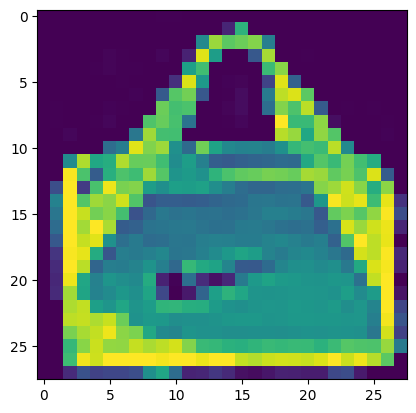

In [51]:
plt.figure()
plt.imshow(img)
plt.show()

In [52]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[-1.550809621810913, -3.7847282886505127, 0.8180496096611023, -1.997605562210083, 0.5929659008979797, 1.016357660293579, 0.43088215589523315, 0.2284543216228485, 3.0695033073425293, 1.1953468322753906]
predicted label: Bag


### 784 columns of float

In [53]:
df = spark.read.parquet(data_path_784)
len(df.columns)

784

In [54]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 270 ms, sys: 66.9 ms, total: 337 ms
Wall time: 3.25 s


In [55]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 264 ms, sys: 71.5 ms, total: 335 ms
Wall time: 1.42 s


In [56]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 275 ms, sys: 75 ms, total: 350 ms
Wall time: 1.28 s


### Check predictions

In [57]:
preds = df.withColumn("preds", mnist(array(*df.columns))).limit(10).toPandas()

In [58]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [59]:
import matplotlib.pyplot as plt
import numpy as np

In [60]:
img = np.array(img).reshape(28,28)

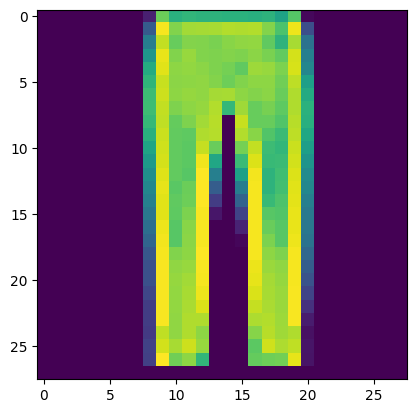

In [61]:
plt.figure()
plt.imshow(img)
plt.show()

In [62]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[ 2.566737    3.822738    0.46219352  3.0394158   1.195469   -2.8100042
  1.2362813  -3.8477216  -2.2566624  -3.1782477 ]
predicted label: Trouser


In [63]:
# This will clear the engine cache (containing previously compiled TensorRT engines) and resets the CUDA Context.
torch._dynamo.reset()

## Using Triton Inference Server
In this section, we demonstrate integration with the [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server), an open-source, GPU-accelerated serving solution for DL.  
We use [PyTriton](https://github.com/triton-inference-server/pytriton), a Flask-like framework that handles client/server communication with the Triton server.  

The process looks like this:
- Distribute a PyTriton task across the Spark cluster, instructing each node to launch a Triton server process.
- Define a Triton inference function, which contains a client that binds to the local server on a given node and sends inference requests.
- Wrap the Triton inference function in a predict_batch_udf to launch parallel inference requests using Spark.
- Finally, distribute a shutdown signal to terminate the Triton server processes on each node.

<img src="../images/spark-pytriton.png" alt="drawing" width="700"/>

In [64]:
from functools import partial

In [65]:
def triton_server(model_path):
    import signal
    import numpy as np
    import torch
    from torch import nn
    import torch_tensorrt as trt
    from pytriton.decorators import batch
    from pytriton.model_config import DynamicBatcher, ModelConfig, Tensor
    from pytriton.triton import Triton
    from pyspark import TaskContext

    print(f"SERVER: Initializing model on worker {TaskContext.get().partitionId()}.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    exp_program = torch.export.load(model_path)
    example_inputs = (torch.randn((50, 784), dtype=torch.float).to("cuda"),)
    trt_gm = trt.dynamo.compile(exp_program,
                                tuple(example_inputs),
                                enabled_precisions={torch.float},
                                workspace_size=1<<30)

    print("SERVER: Compiled model.")

    @batch
    def _infer_fn(**inputs):
        images = inputs["images"]
        if len(images) != 1:
            images = np.squeeze(images)
        stream = torch.cuda.Stream()
        with torch.no_grad(), torch.cuda.stream(stream):
            torch_inputs = torch.from_numpy(images).to(device)
            outputs = trt_gm(torch_inputs)
            return {
                "labels": outputs.cpu().numpy(),
            }

    with Triton() as triton:
        triton.bind(
            model_name="ImageClassifier",
            infer_func=_infer_fn,
            inputs=[
                Tensor(name="images", dtype=np.float32, shape=(-1,)),
            ],
            outputs=[
                Tensor(name="labels", dtype=np.float32, shape=(-1,)),
            ],
            config=ModelConfig(
                max_batch_size=64,
                batcher=DynamicBatcher(max_queue_delay_microseconds=5000),  # 5ms
            ),
            strict=True,
        )

        def stop_triton(signum, frame):
            print("SERVER: Received SIGTERM. Stopping Triton server.")
            triton.stop()

        signal.signal(signal.SIGTERM, stop_triton)

        print("SERVER: Serving inference")
        triton.serve()

def start_triton(url, model_name, model_path):
    import socket
    import psutil
    from multiprocessing import Process
    from pytriton.client import ModelClient

    for conn in psutil.net_connections(kind="inet"):
        if conn.laddr.port == 8001:
            print(f"Process {conn.pid} is already running on port 8001. Please stop it before starting a new one.")
            return []

    hostname = socket.gethostname()
    process = Process(target=triton_server, args=(model_path,))
    process.start()

    client = ModelClient(url, model_name)
    ready = False
    while not ready:
        try:
            client.wait_for_server(5)
            ready = True
        except Exception as e:
            print(f"Waiting for server to be ready: {e}")
    
    return [(hostname, process.pid)]

#### Start Triton servers

To ensure that only one Triton inference server is started per node, we use stage-level scheduling to delegate each task to a separate GPU.  

In [66]:
def _use_stage_level_scheduling(spark, rdd):

    if spark.version < "3.4.0":
        raise Exception("Stage-level scheduling is not supported in Spark < 3.4.0")

    executor_cores = spark.conf.get("spark.executor.cores")
    assert executor_cores is not None, "spark.executor.cores is not set"
    executor_gpus = spark.conf.get("spark.executor.resource.gpu.amount")
    assert executor_gpus is not None and int(executor_gpus) <= 1, "spark.executor.resource.gpu.amount must be set and <= 1"

    from pyspark.resource.profile import ResourceProfileBuilder
    from pyspark.resource.requests import TaskResourceRequests

    spark_plugins = spark.conf.get("spark.plugins", " ")
    assert spark_plugins is not None
    spark_rapids_sql_enabled = spark.conf.get("spark.rapids.sql.enabled", "true")
    assert spark_rapids_sql_enabled is not None

    task_cores = (
        int(executor_cores)
        if "com.nvidia.spark.SQLPlugin" in spark_plugins
        and "true" == spark_rapids_sql_enabled.lower()
        else (int(executor_cores) // 2) + 1
    )

    task_gpus = 1.0
    treqs = TaskResourceRequests().cpus(task_cores).resource("gpu", task_gpus)
    rp = ResourceProfileBuilder().require(treqs).build
    print(f"Reqesting stage-level resources: (cores={task_cores}, gpu={task_gpus})")

    return rdd.withResources(rp)

**Specify the number of nodes in the cluster.**  
Following the README, the example standalone cluster uses 1 node. The example Databricks/Dataproc cluster scripts use 2 nodes by default. 

In [67]:
num_nodes = 1  # Change based on cluster setup

In [68]:
url = "localhost"
model_name = "ImageClassifier"

sc = spark.sparkContext
nodeRDD = sc.parallelize(list(range(num_nodes)), num_nodes)
nodeRDD = _use_stage_level_scheduling(spark, nodeRDD)

Reqesting stage-level resources: (cores=5, gpu=1.0)


In [69]:
pids = nodeRDD.barrier().mapPartitions(lambda _: start_triton(url, model_name, model_path)).collectAsMap()
print("Triton Server PIDs:\n", json.dumps(pids, indent=4))

Triton Server PIDs:
 {
    "cb4ae00-lcedt": 180573
}


#### Define client function

In [70]:
def triton_fn(url, model_name, init_timeout_s):
    from pytriton.client import ModelClient

    print(f"Connecting to Triton model {model_name} at {url}.")

    def infer_batch(inputs):
        with ModelClient(url, model_name, init_timeout_s=init_timeout_s) as client:
            result_data = client.infer_batch(inputs)
            return result_data["labels"]
        
    return infer_batch

#### Run inference

In [71]:
df = spark.read.parquet(data_path_1)
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [72]:
mnist = predict_batch_udf(partial(triton_fn, url=url, model_name=model_name, init_timeout_s=600),
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [73]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 317 ms, sys: 43.1 ms, total: 360 ms
Wall time: 2.52 s


In [74]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 190 ms, sys: 57.4 ms, total: 247 ms
Wall time: 941 ms


In [75]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 201 ms, sys: 41 ms, total: 242 ms
Wall time: 951 ms


Predicted label: Bag


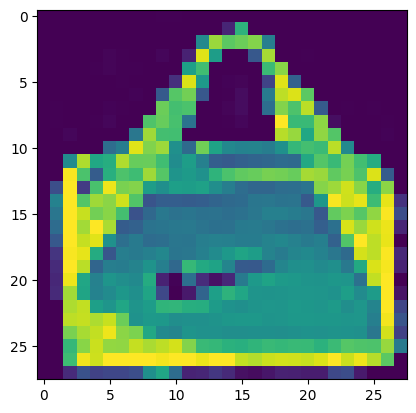

In [76]:
# Sample prediction
sample = preds[0]
predictions = sample.preds
img = sample.data

img = np.array(img).reshape(28,28)
plt.figure()
plt.imshow(img)

print("Predicted label:", classes[np.argmax(predictions)])

#### Stop Triton Server on each executor

In [77]:
def stop_triton(pids):
    import os
    import socket
    import signal
    import time 
    
    hostname = socket.gethostname()
    pid = pids.get(hostname, None)
    assert pid is not None, f"Could not find pid for {hostname}"
    os.kill(pid, signal.SIGTERM)
    time.sleep(7)
    
    for _ in range(5):
        try:
            os.kill(pid, 0)
        except OSError:
            return [True]
        time.sleep(5)

    return [False]

shutdownRDD = sc.parallelize(list(range(num_nodes)), num_nodes)
shutdownRDD = _use_stage_level_scheduling(spark, shutdownRDD)
shutdownRDD.barrier().mapPartitions(lambda _: stop_triton(pids)).collect()

Reqesting stage-level resources: (cores=5, gpu=1.0)


[True]

In [78]:
spark.stop()